# Pedestal Actor notes

In [27]:
using Revise
using FUSE
using IMAS
using Plots;
using Printf;
gr();

## Initialize dd

In [28]:
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

In [29]:
ini.equilibrium.R0 = 4.82
ini.equilibrium.B0 = 4.71
ini.equilibrium.ip = 8e6
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 2.19
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.boundary_from = :scalars

:scalars

In [71]:
#act.ActorOpt.convergence_error = 1e-3
act.ActorOpt.verbose = true
act.ActorEquilibrium.model = :Solovev
act.ActorPedestal.update_core_profiles = true
ini

FUSE.ParametersInits{Float64}
├─ general
│  ├─ casename ➡ "FPP_v1_demount_scalars" Mnemonic name of the case being run
│  └─ init_from ➡ :scalars Initialize run from [:ods, :scalars]
├─ gasc
│  ├─ filename ➡ "/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/cases/../sample/FPPv1.0_aspectRatio3.5_PBpR35_demount.json"
│  │  Output GASC .json file from which data will be loaded
│  └─ case ➡ 0 Number of the GASC run to load
├─ ods
│  └─ filename ➡ missing ODS.json file from which equilibrium is loaded
├─ build
│  ├─ layers ➡ OrderedCollections.OrderedDict{Symbol, Float64}(
│  │           :gap_OH => 1.180137712438599
│  │           :OH => 0.35554973675585266
│  │           :gap_TF_OH => 0.068920461457739
│  │           :hfs_TF => 0.3074802716013343
│  │           :hfs_gap_low_temp_shield_TF => 0.06892046145773922
│  │           :hfs_low_temp_shield => 0.4241901854016936
│  │           :hfs_gap_vacuum_vessel_low_temp_shield => 0.06892046145773945
│  │           :hfs_vacuum_vessel_wall_ou

## Run init and ActorPedestal

Teped = 2.460e+03 eV
neped = 1.007e+20 /m^3


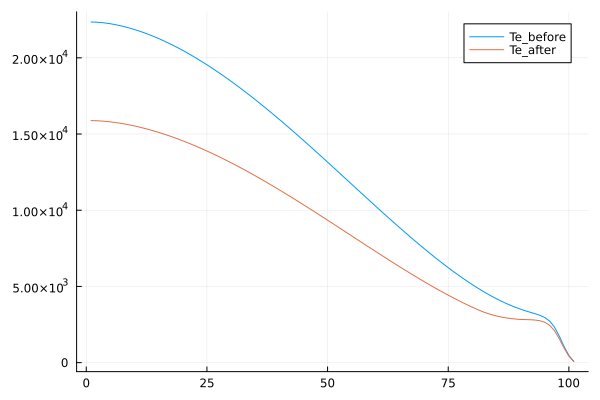

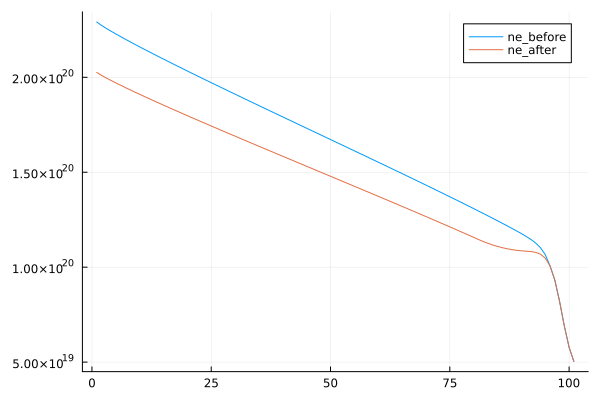

In [32]:
### run init
act.ActorPedestal.update_core_profiles = true

dd = FUSE.init(ini, act)

#@printf("Teped = %.3e eV\n", dd.summary.local.pedestal.t_e.value
#@printf("neped = %.3e /m^3\n", dd.summary.local.pedestal.n_e.value

pte = plot(dd.core_profiles.profiles_1d[].electrons.temperature,label="Te_before")
pne = plot(dd.core_profiles.profiles_1d[].electrons.density,label="ne_before")

FUSE.ActorPedestal(dd, act)
        
@printf("Teped = %.3e eV\n", dd.summary.local.pedestal.t_e.value[1])
@printf("neped = %.3e /m^3\n", dd.summary.local.pedestal.n_e.value[1])

display(plot!(pte,dd.core_profiles.profiles_1d[].electrons.temperature,label="Te_after"))
display(plot!(pne,dd.core_profiles.profiles_1d[].electrons.density,label="ne_after"))


# Run init/pedestal and blend_core_edge_Hmode

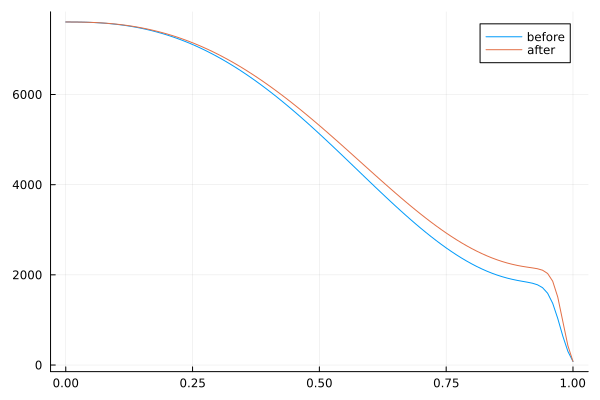

In [73]:
act.ActorPedestal.update_core_profiles = false

ini.equilibrium.pressure_core = 0.5e6
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5

dd = FUSE.init(ini, act)

FUSE.ActorPedestal(dd, act)

rho = dd.core_profiles.profiles_1d[].grid.rho_tor_norm

profile = dd.core_profiles.profiles_1d[].electrons.temperature
ped_height = dd.summary.local.pedestal.t_e.value[]
ped_width = 1 - dd.summary.local.pedestal.position.rho_tor_norm[]
shaping = ini.core_profiles.T_shaping

if false
    profile = dd.core_profiles.profiles_1d[].electrons.density
    ped_height = dd.summary.local.pedestal.n_e.value[]
    ped_width = 1 - dd.summary.local.pedestal.position.rho_tor_norm[]
    shaping = ini.core_profiles.n_shaping
end
    
new_profile = IMAS.Hmode_profiles(profile[end], ped_height, profile[1], length(rho), 2.5, 2.5, ped_width)

plot(rho,profile,label="before")
display(plot!(rho,new_profile,label="after"))


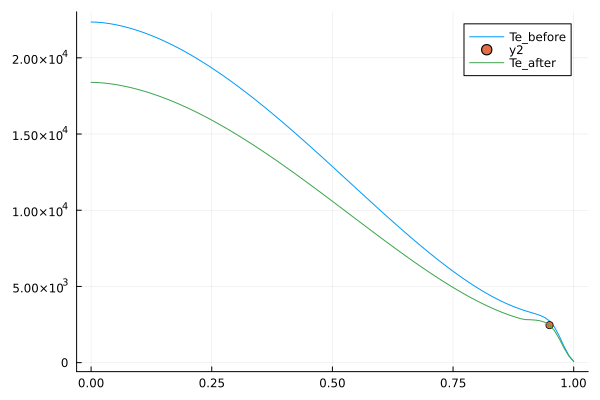

In [59]:
act.ActorPedestal.update_core_profiles = false

dd = FUSE.init(ini, act)

FUSE.ActorPedestal(dd, act)

cp1d = dd.core_profiles.profiles_1d[]
dd_ped = dd.summary.local.pedestal
edge_bound = act.ActorPedestal.edge_bound

#### blend_core_edge_Hmode ####

profile = cp1d.electrons.temperature
rho = cp1d.grid.rho_tor_norm
ped_height = @ddtime(dd_ped.t_e.value)
ped_width = 1 - @ddtime(dd_ped.position.rho_tor_norm)
nml_bound = 0.89
ped_bound = 0.9
expin = 1.2
expout = 1.4

iped = argmin(abs.(rho .- ped_bound))
inml = argmin(abs.(rho .- nml_bound))

z_profile = -IMAS.calc_z(rho, profile)
z_nml = z_profile[inml]

# H-mode profile used for pedestal
profile_ped = IMAS.Hmode_profiles(profile[end], ped_height, -1.0, length(rho), expin, expout, ped_width)

# linear z between nml and pedestal
z_profile_ped = -IMAS.calc_z(rho, profile_ped)
z_ped = z_profile_ped[iped]
z_profile[inml:iped] = (z_nml - z_ped) ./ (rho[inml] - rho[iped]) .* (rho[inml:iped] .- rho[inml]) .+ z_nml

# integrate from pedestal inward
profile_new = deepcopy(profile_ped)
profile_new[1:iped] = IMAS.integ_z(rho[1:iped], z_profile[1:iped], profile_ped[iped])

pte = plot(rho,profile,label="Te_before")
scatter!([dd_ped.position.rho_tor_norm],[ped_height])
display(plot!(pte,rho,profile_new,label="Te_after"))

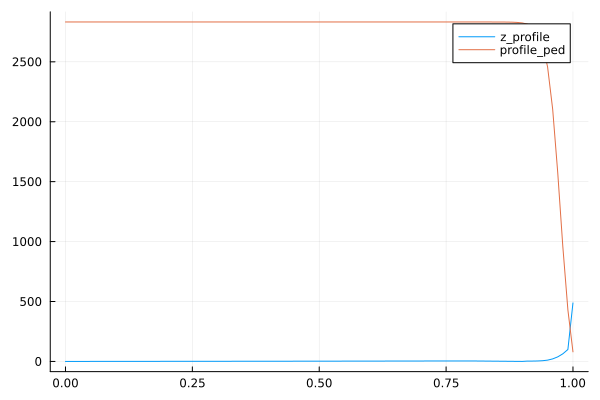

In [54]:
plot(rho,z_profile,label="z_profile")
plot!(rho,profile_ped,label="profile_ped")
